# Staring Array Modelling - Infrared sensor


This notebook forms part of a series on [computational optical radiometry](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi).  The notebooks can be downloaded from [Github](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi). These notebooks are constantly revised and updated, please revisit from time to time.  


[<img src="https://zenodo.org/badge/doi/10.5281/zenodo.9910.png"   align="left"/>](http://dx.doi.org/10.5281/zenodo.9910)


The date of this document and module versions used in this document are given at the end of the file.  
Feedback is appreciated: neliswillers at gmail dot com.   

<font color="red"> This is still a work in progress</font>

## Overview

The pyradi [`rystare`](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html) module models the signal and noise in CCD and CMOS staring array sensors.  The code is originally based on the Matlab code described in *'High-level numerical simulations of noise in solid-state photosensors: review and tutorial'* by Mikhail Konnik and James Welsh, arXiv:1412.4031v1 [astro-ph.IM], available [here](http://arxiv.org/pdf/1412.4031.pdf).

An earlier version (20161020) of a Python version of the model was presented at the Fourth SMEOS conference and was published in SPIE Proc 10036 (2016). The PDF is available here:  
https://github.com/NelisW/pyradi/blob/master/pyradi/documentation/SM200-30-staring-array-modeling.pdf

Good additional references for this work include James R Janesick's books ['Photon Transfer'](http://spie.org/Publications/Book/725073) and ['Scientific Charge-Coupled Devices'](http://spie.org/Publications/Book/374903)

This notebook provides a description of the application of the model to an infrared sensor. Notebooks 09b and 09c provide an overview of the model and its application to a low light level visual sensor.

In [57]:
import numpy as np
import scipy as sp
import pandas as pd
import re
import os.path
from scipy.optimize import curve_fit
import datetime

from matplotlib import cm as mcm
import matplotlib.mlab as mlab
import scipy.constants as const
import collections

import openpyxl as pyxl

%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

# import xlsxwriter

import pyradi.ryplot as ryplot
import pyradi.ryfiles as ryfiles
import pyradi.rystare as rystare
import pyradi.ryutils as ryutils
import pyradi.rypflux as rypflux
import pyradi.ryplanck as ryplanck

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.display import FileLink, FileLinks

#make pngs at stated dpi
import matplotlib as mpl
plotdpi = 72
mpl.rc("savefig", dpi=plotdpi)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'

pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)

# Sensor image radiometry

This description is taken from ''MWIR sensor well fill: sources, effects and mitigation'', Cornelius J. Willers and Tristan M. Goss, Fouth SMEOS Conference, SPIE Proc. 10036, (2016).   The radiometric theory used here was initially  developed by Willers the SPIE book ''Electro-Optical System Analysis and Design: A Radiometry Perspective'', C.J. Willers, Volume PM236, SPIE Press, 2013. http://spie.org/x648.html?product_id=2021423.

## Nonscene flux sources



The contribution of various flux sources (scene, atmospheric path, sources in the optical aperture, including hot optics and narcissus) can be calculated from first principles.  It is very difficult to be completely correct, but with proper care good results can be readily obtained. 
In the analysis done here, the effect of the atmosphere is included in terms of scene flux attenuation and atmospheric path radiance.  Both factors play a significant role in the pixel well fill, particularly under poor atmospheric conditions or for long distance paths.

For an optical medium $\epsilon_\lambda + \rho_\lambda + \tau_\lambda=1$, where $\epsilon_\lambda$ is the medium spectral emissivity, $\rho_\lambda$ is the medium spectral reflectance and $\tau_\lambda$ is the medium spectral transmittance.  Opaque surfaces have $\tau_\lambda=0$ and hence $\epsilon_\lambda = 1 - \rho_\lambda$. Nonreflective surfaces have
$\epsilon_\lambda = 1 - \tau_\lambda$.
Optical media and elements have nonzero emissivity, reflectance \emph{and} transmittance.
The lens elements will reflect the ambient barrel radiance
$\rho_{\lambda\textrm{o}} L_{\lambda}(T_\textrm{barrel})$
and will emit
$\epsilon_{\lambda\textrm{o}}L_{\lambda}(T_\textrm{optics})$,
where
$L_{\lambda}(T)$ is the spectral Planck-law radiation at temperature $T$,
$T_\textrm{barrel}$ the barrel temperature, and
$T_\textrm{optics}$ the optics (window and optical elements) temperature.

![images/Radiometry12.png](images/Radiometry12.png)


## Optical design with no narcissism

The spectral flux emanating from the optics is
$\Phi_\lambda=\Omega_{f}A_{\textrm{det}}\left[\tau_{\lambda\textrm{o}} L_{\lambda\textrm{entPupil}}+\epsilon_{\lambda\textrm{o}} L_\lambda(T_{\textrm{optics}})+\rho_{\lambda\textrm{o}} L_\lambda(T_{\textrm{barrel}})\right]$,
where
$L_{\lambda\textrm{entPupil}} = \tau_{\lambda a}\cos^4\alpha \,L_{\lambda\textrm{scene}} +\cos^3\alpha \, L_{\lambda\textrm{path}}$ is the flux in the entrance pupil (coming from outside the sensor),
$\alpha$ is the optics field angle,
$\tau_{\lambda a}$ is the atmospheric transmittance to the scene,
$L_{\lambda\textrm{scene}}=\epsilon_{\lambda\textrm{s}}L_\lambda(T_\textrm{scene}) $
is the scene radiance,
$\epsilon_{\lambda\textrm{s}} $ is the scene emissivity,
$L_{\lambda\textrm{path}}$ is the atmospheric path radiance,
$\Omega_{f}$ is the f-number cone solid angle,
$A_{\textrm{det}}$ is the detector area,
$\tau_{\lambda\textrm{o}}$ is the optics transmittance,
$\epsilon_{\lambda\textrm{o}}$ is the optics emissivity, and
$\rho_{\lambda\textrm{o}}$ is the optics reflectance.
Assuming that the barrel and optics are at the same temperature $T_{\textrm{optics}}=T_{\textrm{barrel}}$,
then
$\Phi_\lambda=\Omega_{f}A_{\textrm{det}}\left[\tau_{\lambda\textrm{o}} L_{\lambda\textrm{entPupil}}+ L_\lambda(T_{\textrm{optics}})(\epsilon_{\lambda\textrm{o}}+\rho_{\lambda\textrm{o}})\right],$
but
$(\epsilon_{\lambda\textrm{o}}+\rho_{\lambda\textrm{o}}) L_\lambda(T_{\textrm{optics}}) = (1-\tau_{\lambda\textrm{o}})L_\lambda(T_{\textrm{optics}})$.
Then
$\Phi_\lambda=\Omega_{f}A_{\textrm{det}}\left[\tau_{\lambda\textrm{o}} L_{\lambda\textrm{entPupil}}+ L_\lambda(T_{\textrm{optics}})(1-\tau_{\lambda\textrm{o}})\right]$,
hence the optics' 'effective emissivity' can be considered as everything that is not transmittance, leading to the simple model
$\epsilon_{\lambda\textrm{o}} = 1 -  \tau_{\lambda\textrm{o}}$, and similarly for the filter
$\epsilon_{\lambda\textrm{f}} = 1 -  \tau_{\lambda\textrm{f}}$.  This model only applies if $T_{\textrm{optics}}=T_{\textrm{barrel}}$, which is generally the case.
Atmospheric path radiance is weighted with $\cos^3\alpha$ accounting for a  $\cos\alpha$ on detector incidence angle and $R^2/\cos^2\alpha$ on the slant chief ray.
The $\cos^4\alpha$ factor for the scene additionally includes a $\cos\alpha$ on object incidence angle when viewing a small object with normal vector parallel with the optical axis.  This additional $\cos\alpha$ factor does not normally apply to an imaging sensor where the objects size exceeds the detector pixel footprint.
The obstructions are assumed located between the lens and the detector, partially obscuring the lens radiance. If the obscuration, optics and barrel are all at the same temperature, this is a reasonable assumption.  If the obscuration elements are located in front of the lens, $(1-\epsilon_{\lambda\textrm{o}} - \rho_{\lambda\textrm{o}})L_\lambda(T_{\textrm{barrel}})$ will be transmitted, $\epsilon_{\lambda\textrm{o}} L_\lambda(T_{\textrm{barrel}})$ will be emitted and $\rho_{\lambda\textrm{o}} L_\lambda(T_{\textrm{barrel}})$  will reflect from the optical barrel, adding up to the radiance of an obscuration located behind the lens.  The optics and barrel form a closed cavity and it is assumed that the effective barrel emissivity is unity $\epsilon_{\lambda\textrm{b}}=1$.




## Optical design with narcissism

![images/Radiometry16.png](images/Radiometry16.png)


Narcissism is the phenomenon where the detector flux is reflected from one or more optical surfaces onto itself.  It is modeled as a rotatioanlly symmetric, spectrally constant, but field-angle-dependent reflective term $\rho_n$, computed over the full optics aperture. The value  of $\rho_n$ is determined by ray tracing, counting the fraction of rays emanating from the detector, that fall back onto the detector (reflection from the optics). 
 This reflectance value is then used to reflect the cold stop onto itself, resulting in a negative/colder radiance compared to the hotter/positive radiance from the scene.


The scene flux and the optics' emitted flux are not affected by the narcissism.  The reflectance from the optics now has two components, the reflected narcissism component and the reflected barrel component.
With narcissism present, the total flux emanating from the lens elements is
\begin{equation}
\Phi_\lambda=\Omega_{f}A_{\textrm{det}}\left[\tau_{\lambda\textrm{o}} L_{\lambda\textrm{entPupil}}+\epsilon_{\lambda\textrm{o}} L_\lambda(T_{\textrm{optics}})+(\rho_{\lambda\textrm{o}} - \rho_{\textrm{n}}) L_\lambda(T_{\textrm{barrel}})+\rho_{\textrm{n}}\epsilon_{\lambda\textrm{c}} L_\lambda(T_{\textrm{cold}})\right],
\end{equation}
where $T_{\textrm{cold}}$ is the cold shield temperature (assumed approximately the same as the detector temperature), and $\epsilon_{\lambda\textrm{o}}$ is the cold shield cavity emissivity.
Assuming that the barrel and optics are at the same temperature $T_{\textrm{optics}}=T_{\textrm{barrel}}$ and $(\epsilon_{\lambda\textrm{o}}+\rho_{\lambda\textrm{o}}) L_\lambda(T_{\textrm{optics}}) = (1-\tau_{\lambda\textrm{o}})L_\lambda(T_{\textrm{optics}})$,
then
\begin{equation}
\Phi_\lambda=\Omega_{f}A_{\textrm{det}}\left[\tau_{\lambda\textrm{o}} L_{\lambda\textrm{entPupil}}+(1-\tau_{\lambda\textrm{o}})L_\lambda(T_{\textrm{optics}})- \rho_{\textrm{n}}\left[L_\lambda(T_{\textrm{optics}}) - \epsilon_{\lambda\textrm{o}}L_\lambda(T_{\textrm{cold}})\right]\right].
\end{equation}
$\left[L_\lambda(T_{\textrm{optics}}) - \epsilon_{\lambda\textrm{o}}L_\lambda(T_{\textrm{cold}})\right]$ can be significant for a cryogenically cooled detector, and therefore, even small amounts of narcissism can contribute to reducing the flux on the detector.



## Well fill

The contribution of the various elements to the total flux on the detector can be calculated from the elements' solid angles and radiances within each solid angle.  For the first order analysis the radiance values are assumed  uniform in the elements' solid angle. If the radiating sources are not uniform, the values used here can be considered the mean values of the respective radiators.
The model shown here calculates the flux on the central pixel in the image. The values for other pixels will be slightly different, resulting from different solid angles to these pixels.
The elements identified in this analysis and their solid angles are shown above. 
The spectral irradiance on the detector  (calculated in photon rate   $L_{q\lambda}(T)$) is given by
\begin{eqnarray}
E_{\lambda\textrm{det}} = \frac{\Phi_{\lambda\textrm{det}}}{A_{\textrm{det}}}
&=&
+(\Omega_3 -\Omega_4 - \Omega_5 )\left[
 \tau_{\lambda\textrm{o}}\tau_{\lambda f} L_{\lambda\textrm{entPupil}} +
\tau_{\lambda f}(1 -\tau_{\lambda\textrm{o}}) L_{\lambda}(T_{\textrm{optics}})\right]\nonumber\\
&&+
(\Omega_3 -\Omega_4 - \Omega_5)\tau_{\lambda f}
\rho_{n} \left[
\epsilon_{\lambda\textrm{o}}L_{\lambda}(T_{\textrm{cold}})
-
L_{\lambda}(T_{\textrm{optics}})
\right]
\nonumber\\
&&+
\Omega_3  (1 -\tau_{\lambda f}) L_{\lambda}(T_{\textrm{filter}})
+
\Omega_4 \tau_{\lambda f} \epsilon_{\lambda\textrm{a-obs}} L_{\lambda}(T_{\textrm{a-obs}}) \nonumber\\
&&+
\Omega_5 \tau_{\lambda f} \epsilon_{\lambda\textrm{c-obs}}  L_{\lambda}(T_{\textrm{c-obs}})
+
\Omega_{2b}\tau_{\lambda f}\epsilon_{\lambda\textrm{barrel}} L_{\lambda}(T_{{\textrm{barrel}}})\nonumber\\
&&+
\Omega_{2a}\epsilon_{\lambda\textrm{barrel}} L_{\lambda}(T_{{\textrm{barrel}}})
+
\Omega_{1}\epsilon_{\lambda\textrm{c}} L_{\lambda}(T_{{\textrm{cold}}}),
\end{eqnarray}
where
$T_{\textrm{filter}}$ is the filter  temperature (filter can be warm or cold),
$T_{\textrm{cold}}$ is the cold shield temperature,
$T_{\textrm{a-obs}}$ is any asymmetric obscuration temperature (if present),
$T_{\textrm{c-obs}}$ is the central obscuration temperature,
$T_{\textrm{cold}}$ is the detector/cold shield temperature,
$\rho_{n}$ is the narcissus reflectance (a function of field angle and rotational angle),
$\tau_{\lambda f}$ is the filter transmittance,
$\epsilon_{\lambda\textrm{barrel}}$ is the barrel spectral emissivity,
$\epsilon_{\lambda\textrm{a-obs}}$ is the asymmetric  obscuration spectral emissivity,
$\epsilon_{\lambda\textrm{c-obs}}$ is the central obscuration spectral emissivity, and
$\epsilon_{\lambda\textrm{c}}$ is the cold shield spectral emissivity.


The projected optics solid angle is given by
$\Omega_3 = \pi\sin^2\theta = \pi(\textrm{NA})^2 = \pi/(2F_\#)^2$
where $\theta$ is the half apex angle of the f-number cone, and $\textrm{NA}$ is the optics numerical aperture.  Other solid angles are derived similarly from the sensor geometry.
The normalized  well fill is calculated as
\begin{equation}
W_f = \eta\, E_{\textrm{det}}\, A_{\textrm{det}}\, t_i \,/ \,W_c,
\end{equation}
where
$\eta$ is the detector quantum efficiency,
$W_f$ is the actual normalized well fill,
$E_{\textrm{det}}$ is the spectrally integrated irradiance on the detector,
$A_{\textrm{det}}$ is the area of the detector,
$t_i$ is the integration time, and
$W_c$ is total well capacity of the detector charge well (integration capacitor).



## Scene content

Assuming no obscruration and ignoring barrel and filter radiance, but keeping the optics, narcissus and scene radiance the equation simplifies to the radiance in the f-number solid angle $\Omega_f$ at the detector as 

\begin{eqnarray}
L_{\lambda\textrm{det}} = \frac{\Phi_{\lambda\textrm{det}}}{\Omega_3A_d}
&=&
\tau_{\lambda f}\tau_{\lambda o}\tau_{\lambda a}\cos^4\alpha\, L_{\lambda}(T_{\textrm{scene}}) 
+
\tau_{\lambda f}\tau_{\lambda o}\cos^3\alpha\, L_{\lambda\textrm{path}}
+
\tau_{\lambda f}(1 -\tau_{\lambda o}) L_{\lambda}(T_{\textrm{optics}})
+
\tau_{\lambda f}\rho_{n}(\alpha,r) \left[
L_{\lambda}(T_{\textrm{cold}})
-
L_{\lambda}(T_{\textrm{optics}})
\right]
\end{eqnarray}


Assuming narcissism to be rotationally symmetrical $\rho_{n}(\alpha,r) =\rho_{n}(\alpha) $ and asumming horizontal paths close to the ground the path radiance can be written as $(1-\tau_{\lambda a}) L_{\lambda}(T_{\textrm{scene}})$. Also the $\cos^4\alpha$ factor often on average degrades to $\cos^3\alpha$ for random target orientations.


\begin{eqnarray}
L_{\lambda\textrm{det}} = \frac{\Phi_{\lambda\textrm{det}}}{\Omega_3A_d}
&=&
\tau_{\lambda f}\tau_{\lambda o}\cos^3\alpha
\left[
\tau_{\lambda a} L_{\lambda}(T_{\textrm{scene}}) 
+
(1-\tau_{\lambda a}) L_{\lambda}(T_{\textrm{scene}})
\right]
+
\tau_{\lambda f}(1 -\tau_{\lambda o}) L_{\lambda}(T_{\textrm{optics}})
+
\tau_{\lambda f}\rho_{n}(\alpha,r) \left[
L_{\lambda}(T_{\textrm{cold}})
-
L_{\lambda}(T_{\textrm{optics}})
\right]
\end{eqnarray}



The integration time is calculated according to the upper-end radiance in the scene dynamic range. With the integration time known, the minimum/lower scene radiance is determined.  An externally-created infrared scene image can then be mapped such that the two minima align and the two maxima align.  This provides an image with a realistic infrared content, scaled into the well-fill range according to the appropriate sensor radiometry.

Considering the dynamic range in the scene that must be represented in the image the minimum and maximum radiance values are

\begin{eqnarray}
L_{\textrm{Min-det}}
&=&
\tau_{\lambda f}\tau_{\lambda o}\cos^3\alpha
\left[
\tau_{\lambda a} L_{\lambda}(T_{\textrm{scene}}) 
+
(1-\tau_{\lambda a}) L_{\lambda}(T_{\textrm{scene}})
\right]
+
\tau_{\lambda f}(1 -\tau_{\lambda o}) L_{\lambda}(T_{\textrm{optics}})
+
\tau_{\lambda f}\rho_{n}(\alpha,r) \left[
L_{\lambda}(T_{\textrm{cold}})
-
L_{\lambda}(T_{\textrm{optics}})
\right]
\end{eqnarray}

\begin{eqnarray}
L_{\textrm{Max-det}} 
&=&\int_0^\infty\left(
L_{\lambda\textrm{Min-det}}
-
\tau_{\lambda a}\tau_{\lambda f}\tau_{\lambda o}\cos^3\alpha
\left[
L_{\lambda}(T_{\textrm{scene-min}}) 
-
L_{\lambda}(T_{\textrm{scene-min}}+T_{\textrm{dynamic}}) 
\right]
\right)d\lambda
\end{eqnarray}

The value $L_{\lambda\textrm{Max-det}}$ corresponds to the maximum well fill allowed (as adjusted by setting the integration time) and $L_{\lambda\textrm{Min-det}}$ corresponds to the DC level in the well fill (the coldest object in the scene).

Calculating the well fill from $W_f = \eta\, L_{\textrm{det}}\,\Omega_3\, A_d\, t_i \,/ (W_c)$ leading to



To map an image with arbitrary grey-level scale to fill the charge well to the desired levels, execute the following algorithm:

1. From the problem definition decide on values for 
$\eta$, 
$A_d$, 
$W_c$,
$\Omega_3$,
$\tau_{\lambda f}$, 
$\tau_{\lambda o}$, 
$T_{\textrm{scene-min}}$,
$T_{\textrm{optics}}$,
$T_{\textrm{cold}}$, and 
$T_{\textrm{dynamic}}$.

2. For the initial calculations find scalar values that may give max well fill for 
$\alpha$ (e.g., max alpha), and $\rho_{n}(\alpha)$ (e.g., the maximum value).

3. Decide on a value of $W_{\textrm{Max-det}}$

4.  Use the target value for $W_{\textrm{Max-det}}$ together with all the other known values to calculate the integration time $t_i$.
\begin{equation}
t_i = 
\frac{W_{\textrm{Max-det}} W_c}{ A_d\, \Omega_3\,}\cdot
\frac{1}{\int_0^\infty \eta\,\left(
L_{\lambda\textrm{Min-det}}
-
\tau_{\lambda a}\,\tau_{\lambda f}\tau_{\lambda o}\cos^3\alpha
\left[
L_{\lambda}(T_{\textrm{scene-min}}) 
-
L_{\lambda}(T_{\textrm{scene-min}}+T_{\textrm{dynamic}}) 
\right]
\right)d\lambda}
\end{equation}

5. Use the integration time $t_i$ and all the other known parameters to calculate $W_{\textrm{Min-det}}$.
\begin{equation}
W_{\textrm{Min-det}} 
= \frac{A_d\, \Omega_3\, t_i}{W_c} \int_0^\infty \eta\,\left(
L_{\lambda\textrm{Min-det}}
\right)d\lambda
\end{equation}

6. Scale the input image grey level values to fall between the two limits $W_{\textrm{Min-det}}$ and $W_{\textrm{Max-det}}$.  At this point the image will have electron count values with appropriate well fill.

7. Calculate the narcissus signal offset and add to the image

\begin{eqnarray}
L_{\textrm{Narc-det}}
&=&
\tau_{\lambda f}\rho_{n}(\alpha,r) \left[
L_{\lambda}(T_{\textrm{cold}})
-
L_{\lambda}(T_{\textrm{optics}})
\right]
\end{eqnarray}

\begin{eqnarray}
W_{\textrm{Narc-det}}
&=&
\rho_{n}(\alpha,r)\, \Omega_3\, A_d\, t_i \,
\int_0^\infty \eta\,\tau_{\lambda f} \left[
L_{\lambda}(T_{\textrm{cold}})
-
L_{\lambda}(T_{\textrm{optics}})
\right]d\lambda
\end{eqnarray}


In [58]:
# to define Selex detector properties
"""This  dict defines the detector parameters
"""

dDetectorSpec = {
    'Falcon':{
        'WellCapacity':3.2e6,
        'eta':0.5,
        'fnumber':3.2,
        'pitch':12e-6,
        'fillfactor':0.95,    
    },
    'Super Hawk':{
        'WellCapacity':3.1e6,
        'eta':0.5,
        'fnumber':3.2,
        'pitch':12e-6,
        'fillfactor':0.95,
    } 
}


In [62]:
# to define the input file name and define ranges in the spreadsheet
def readXLSnarcissus(inputfilename, sheet, wrange,colnames, position,field,rotang):
    """
    """
    
    #load the narcissus electron count vs field angle
    wb = pyxl.load_workbook(inputfilename)
    # print(wb.get_sheet_names())
    ws = wb[sheet]

    #read the table from excel into dataframe, dropping some cols
    table = np.array([[cell.value for cell in col] for col in ws[wrange[0]:wrange[1]]])
    dfTable = pd.DataFrame(table, columns=colnames)
    # where possible convert all to numpy floats
    for ccol in dfTable.columns:
        try:
            dfTable[ccol] = dfTable[ccol].astype(np.float64)
        except:
            pass
        
    narcProf = dfTable[position]

    profnarc = np.interp(field.reshape(-1,1), dfTable['Field'], dfTable[position])
    meshnarc = profnarc * np.ones(rotang.reshape(1,-1).shape)

    return meshnarc,profnarc

ls = ['Field','5','5.5','6','7','8','9.5','11.5','14','17','21','29','40']


# normalised field angle; the number of samples here is final output image size
field = np.linspace(0.,1.,100)
# rotational angle
rotang = np.linspace(0., 2.0 * np.pi, 720)
readXLSnarcissus('data/09d-narcsissus.xlsx',sheet=u'MWZoom',wrange=['A7','M32'],colnames=ls, position='5',field=field,rotang=rotang)

(array([[ 0.06135045,  0.06135045,  0.06135045, ...,  0.06135045,
          0.06135045,  0.06135045],
        [ 0.06132978,  0.06132978,  0.06132978, ...,  0.06132978,
          0.06132978,  0.06132978],
        [ 0.06130911,  0.06130911,  0.06130911, ...,  0.06130911,
          0.06130911,  0.06130911],
        ..., 
        [ 0.03809828,  0.03809828,  0.03809828, ...,  0.03809828,
          0.03809828,  0.03809828],
        [ 0.03749054,  0.03749054,  0.03749054, ...,  0.03749054,
          0.03749054,  0.03749054],
        [ 0.0368828 ,  0.0368828 ,  0.0368828 , ...,  0.0368828 ,
          0.0368828 ,  0.0368828 ]]), array([[ 0.06135045],
        [ 0.06132978],
        [ 0.06130911],
        [ 0.06128844],
        [ 0.06126627],
        [ 0.06120801],
        [ 0.06114974],
        [ 0.06109148],
        [ 0.06103188],
        [ 0.06095689],
        [ 0.06088191],
        [ 0.06080692],
        [ 0.06073565],
        [ 0.06069157],
        [ 0.06064748],
        [ 0.0606034 ],
     

In [48]:
images = {
    'PtaDesert':{
        'rows':6144,
        'cols':6144,
        'aspect':[1,1],
        'path':'IR-background-images',
        'files':['PtaDesert-13Dec07h00.bin','PtaDesert-13Dec14h00.bin','PtaDesert-13Dec18h00.bin',
                'PtaDesert-13June07h00.bin','PtaDesert-13June14h00.bin','PtaDesert-13June18h00.bin']
    },
    'PtaInd':{
        'rows':7680,
        'cols':7680,
        'aspect':[1,1],
        'path':'IR-background-images',
        'files':['PtaInd-13Dec07h00.bin','PtaInd-13Dec14h00.bin','PtaInd-13Dec18h00.bin',
                'PtaInd-13June07h00.bin','PtaInd-13June14h00.bin','PtaInd-13June18h00.bin']
    },
    'boat-bw':{
        'rows':2592,
        'cols':3872,
        'aspect':[2,1],
        'path':'images',
        'files':['boat-bw.png']
    },
}


In [49]:
# to read an input image
def readImage(filename, rows=None, cols=None, vartype=np.float64, loadFrames=[0] ):
    if '.png' in filename:
        return sp.ndimage.imread(filename, flatten=True, mode=None)
    elif '.bin' in filename:
        nfr,img = ryfiles.readRawFrames(filename, rows=rows, cols=cols, 
                                        vartype=vartype, loadFrames=loadFrames)
        return img[0,:,:]
        
    return None

In [50]:
# to read image sizes
for froot in images.keys():
    img = readImage('{}/{}'.format(images[froot]['path'],images[froot]['files'][0]), 
                    rows=images[froot]['rows'], cols=images[froot]['cols'])
    print(froot,img.shape)
    

IOError: [Errno 2] No such file or directory: 'images/boat-bw.png'

In [51]:
# to calculate the well fill, integration time and optics solid angle
def calcTintWellFill(waven, eta, areaDet,fnumber, wellcapacity, taufilter, tauoptics, 
                    taua,tempSceneMin,tempOptics,tempCold,tempDynamic,
                    alpha, maxNarc,wellFilMax):
    
    """calculate values for integration time and min and max well fill according to scenario
    
    Input:  
    waven wavenumber vector cm-1
    eta quantum efficiency
    areaDet detector area m2
    wellcapacity well capacity e
    taufilter
    tauoptics
    tempSceneMin minimum temp in the scene K
    tempOptics
    tempCold
    tempDynamic difference between max and min temp in the scene
    alpha field angle
    rhonarc narcissus field angle
    wellFilMax normalised value [0..1]
    wellFilMin normalised value [0..1]
     
    """ 
    # For the initial calculations assume the image-averaged value for 
    # $\rho_{n}(\alpha)$ (e.g., the maximum value).
    
    solidAng = np.pi / (2 * fnumber)**2
    # calculate the minimum radiance for all contributors
    # scene minimum on optical axis  
    Lscenemin = taua * taufilter * tauoptics * ryplanck.planck(waven, tempSceneMin, 'qn')
    # scene maximum on optical axis  
    Lscenemax = taua * taufilter * tauoptics * ryplanck.planck(waven, tempSceneMin+tempDynamic, 'qn')
    # path on optical axis 
    Lpathmax = (1-taua) * taufilter * tauoptics * ryplanck.planck(waven, tempSceneMin, 'qn')
    # optics constant value
    Loptics = taufilter * (1. - tauoptics) * ryplanck.planck(waven, tempOptics, 'qn')
    # narc constant value at max narc
    Lnarc = taufilter * maxNarc * (ryplanck.planck(waven, tempCold, 'qn')-ryplanck.planck(waven, tempOptics, 'qn'))
    
    # max value is on axis
    LMaxdet = (Lscenemax + Lpathmax + Loptics + Lnarc) 
    
    #calc integration time from prescribed max well fill
    tint = wellFilMax * wellcapacity / (areaDet * solidAng)
    tint /= (np.trapz(eta * LMaxdet.reshape(-1, 1),waven, axis=0)[0])
    
    wffactor = areaDet * solidAng * tint
    wellFillHotOpt = wffactor * (np.trapz(eta * Loptics.reshape(-1, 1),waven, axis=0)[0])
    wellFillPath = wffactor * (np.trapz(eta * Lpathmax.reshape(-1, 1),waven, axis=0)[0])
    wellFillSmin = wffactor * (np.trapz(eta * Lscenemin.reshape(-1, 1),waven, axis=0)[0])
    wellFillSmax = wffactor * (np.trapz(eta * Lscenemax.reshape(-1, 1),waven, axis=0)[0])
    wellFillLnarc = wffactor * (np.trapz(eta * Lnarc.reshape(-1, 1),waven, axis=0)[0])
        
    return tint, solidAng, wellFillHotOpt, wellFillPath, wellFillSmin, wellFillSmax, wellFillLnarc
    
# test code    
waven = np.linspace(10000./4.8,10000./3.5,100)
eta=.5
areaDet=0.95*(12e-6)**2
fnumber=3.2
wellcapacity=3e6
taufilter=0.8
tauoptics=0.7
taua=0.6
tempSceneMin=300.
tempOptics=320.
tempCold=100.
tempDynamic=40.
alpha=0.
maxNarc=0.07
wellFilMax=0.9


tint, solidAng, wellFillHotOpt, wellFillPath, wellFillSmin, wellFillSmax,wellFillLnarc = \
                        calcTintWellFill(waven, eta=eta, areaDet=areaDet,
                          fnumber=fnumber, wellcapacity=wellcapacity, 
                          taufilter=taufilter, tauoptics=tauoptics, 
                          taua=taua,tempSceneMin=tempSceneMin,
                          tempOptics=tempOptics,tempCold=tempCold,
                          tempDynamic=tempDynamic, alpha=alpha, 
                          maxNarc=maxNarc,wellFilMax=wellFilMax)    

print('Test example:')
print('Integration time is {:.2f} ms'.format(1e3*tint))
print('solidAng  is {:.2f} ms'.format(solidAng))
print('wellFillHotOpt  is {:.2f} e'.format(wellFillHotOpt))
print('wellFillPath  is {:.2f} e'.format(wellFillPath))
print('wellFillSmin  is {:.2f} e'.format(wellFillSmin))
print('wellFillSmax  is {:.2f} e'.format(wellFillSmax))
print('wellFillLnarc  is {:.2f} e'.format(wellFillLnarc))
print('wellFill max  is {:.2f} e'.format(wellFillHotOpt+wellFillPath+wellFillSmax+wellFillLnarc))
print('wellFill max  is {:.2f} %'.format((wellFillHotOpt+wellFillPath+wellFillSmax+wellFillLnarc)/wellcapacity))


Test example:
Integration time is 3.09 ms
solidAng  is 0.08 ms
wellFillHotOpt  is 707601.15 e
wellFillPath  is 331135.31 e
wellFillSmin  is 496702.96 e
wellFillSmax  is 1826370.48 e
wellFillLnarc  is -165106.93 e
wellFill max  is 2700000.00 e
wellFill max  is 0.90 %


In [52]:
def readNarcissus(iplt,narcfile,position,detector,field,rotang,dTMGnarc,
                plotNarcProfile=False,plotNarcImages=False):
    
    meshnarc,profnarc = readXLSnarcissus(narcfile,position,field,rotang)    
    #  meshnarc is a (r,theta) image, now convert to (x,y) with r==0 in the center
    meshnarc_cartCirc = ryutils.warpPolarImageToCartesianImage(meshnarc)
    # now we have the narcissus in (xy) coords, but for a full 2r disc

    if plotNarcProfile:
        iplt += 1
        p = ryplot.Plotter(iplt,1,1,figsize=(12,5))
        p.plot(1,field, meshnarc[:,0],
            'Narcissus reflection',
            'Normalised field angle','',label=['{}'.format(position)])

    if plotNarcImages:
        iplt += 1
        n2 = ryplot.Plotter(iplt,1,2,figsize=(12,5))
        n2.showImage(1,meshnarc, ptitle='Narcissus (r,theta)', cmap='gray', titlefsize=10,  
                    cbarshow=True,cbarfontsize = 8);
        n2.showImage(2,meshnarc_cartCirc, ptitle='Narcissus (x,y) circular', cmap='gray', titlefsize=10,  
                    cbarshow=True,cbarfontsize = 8);

    return meshnarc_cartCirc, iplt, meshnarc, profnarc


In [ ]:
# to calculate the degraded image

def calcWellFillImage(narcfile, irInImgRawfn, dDetectorSpec=dDetectorSpec,detector='Falcon',
                    outImgSize = 512, doPhotNoise = True,doPRNU = False,
                    narcScale = 1.0, NU = 0.016,
                    taufilter=0.8,tauoptics=0.7,taua=0.3,tempSceneMin=300.,
                    tempOptics=320.,tempCold=100.,tempDynamic=40.,
                    wellFilMax=0.9,saveImages=False,position='4.8d 176.0mm',
                    iplt=0,plotStats=False,plotNarcProfile=False,plotDifference=False,
                    plotNarcImages=False,wllo=3.5,wlhi=4.8,
                    inputImgAsp = [9,16],doCosAlpha=False):

    """
    narcfile (string) filename of file containing the narcissus info
    irInImgRawfn (string) raw IR input image filename
    dDetectorSpec (dict) containing the detector spec
    detector (string) containing the detector name as key into dDetectorSpec
    outImgSize (int) output image size 
    wellFilMax (float) the maximum well fill for max scene flux
    position (string) id for the zoom lens position
    taua (float) atmospheric transmittance
    taufilter (float) filter transmittance
    tauoptic (float) optics transmittance
    NU (float) residual nonuniformity (normalised)
    doPRNU (bool) switches nonuniformity on/off
    doPhotNoise (bool) switches photon noise on/off
    tempSceneMin (float) minimum temperature in the scene
    tempCold (float) cold shield temperature
    tempDynamic (float) dynamic range in the image
    tempOptics (float)  optics temperature
    iplt (int) keep track of plot IDs
    saveImages (bool) (de)activate saving images to disk
    plotStats (bool) (de)activate plotting statistics
    plotNarcProfile (bool) (de)activate plotting narcissus profile
    plotDifference (bool) (de)activate plotting difference between before and after
    plotNarcImages (bool) (de)activate plotting narcissus images
    narcScale (float) scaling factor to adjust narc profile
    wllo (float) lower wavelength limit
    wlhi (float) upper wavelength limit
    inputImgAsp ([9,16]) defines image aspect ratio   
    doCosAlpha if true include cosine^3alpha
        
    """

    irInImgRaw = readImage('{}/{}'.format(images[irInImgRawfn]['path'],images[irInImgRawfn]['files'][0]), 
                rows=images[irInImgRawfn]['rows'], cols=images[irInImgRawfn]['cols'])

    
    waven = np.linspace(10000./wlhi,10000./wllo,100)

    eta = dDetectorSpec[detector]['eta']
    wellcapacity = dDetectorSpec[detector]['WellCapacity']
    fnumber = dDetectorSpec[detector]['fnumber']
    areaDet = dDetectorSpec[detector]['fillfactor']*(dDetectorSpec[detector]['pitch'])**2.

    # extract the FOV from position
    fovdegH = float(position.split('d')[0])
    #this FOV is full angle horizontal, now calculate half angle diagonal
    fovradD = (np.pi/180.) * (fovdegH/2.) * \
            np.sqrt((inputImgAsp[0]/2.)**2. + (inputImgAsp[1]/2.)**2.) / (inputImgAsp[1]/2.)
    
    
    if doCosAlpha:
        cosalpha = 1.
        cosalp = '*'
    else:
        cosalpha = 1.
        cosalp = ''

    str1 = '{} {} Tscene={:.0f} K, tauA={:.2f}%, Toptics={:.0f} K, '.format(
                position,cosalp,tempSceneMin,taua,tempOptics)
    str2 = 'tauO={:.2f}%, Tcold={:.0f} K, TDyn={:.0f} K, NU={}'.format(tauoptics,
                                            tempCold,tempDynamic,doPRNU*NU)
    strScen = str1 + str2
    strFile = strScen.replace(' ','-')

    # normalised field angle; the number of samples here is final output image size
    field = np.linspace(0.,1.,outImgSize)
    # rotational angle
    rotang = np.linspace(0., 2.0 * np.pi, 720)

    # read the narcissus
    meshnarc_cartCirc,iplt,_,_ = readNarcissus(iplt,narcfile,position,detector,field,rotang,
                    None,plotNarcProfile=plotNarcProfile,plotNarcImages=plotNarcImages)  
    
    # now clip narcr image to sensor aspect ratio
    # calculate clipping window dimensions
    aspect = np.asarray(inputImgAsp)
    aspectRad = np.linalg.norm(aspect)
    clip0 = np.asarray([0.5 - aspect[0]/(2*aspectRad), 0.5 + aspect[0]/(2*aspectRad), 
                        0.5 - aspect[1]/(2*aspectRad), 0.5 + aspect[1]/(2*aspectRad)])
    # scale the normalised clip window to max dimension
    clip = (clip0 * meshnarc_cartCirc.shape[0]).astype(np.int64)
    # clip & remove crappy zero in the corner(s)
    meshnarc_cart = meshnarc_cartCirc[clip[0]+2:clip[1]-2,clip[2]+2:clip[3]-2]

    # calc the well fill, integration time and optics solid angle
    tint, solidAng, wellFillHotOpt, wellFillPath, wellFillSmin, wellFillSmax, wellFillLnarc = \
                            calcTintWellFill(waven, eta=eta, areaDet=areaDet,
                              fnumber=fnumber, wellcapacity=wellcapacity, 
                              taufilter=taufilter, tauoptics=tauoptics, 
                              taua=taua,tempSceneMin=tempSceneMin,
                              tempOptics=tempOptics,tempCold=tempCold,
                              tempDynamic=tempDynamic, alpha=fovradD, 
                              maxNarc = np.max(meshnarc_cart),wellFilMax=wellFilMax)        
       
    print('Integration time is {:.2f} ms'.format(1e3*tint))
    print('solidAng  is {:.2f} ms'.format(solidAng))
    print('wellFillHotOpt  is {:.2f} e'.format(wellFillHotOpt))
    print('wellFillPath  is {:.2f} e'.format(wellFillPath))
    print('wellFillSmin  is {:.2f} e'.format(wellFillSmin))
    print('wellFillSmax  is {:.2f} e'.format(wellFillSmax))
    print('wellFillLnarc  is {:.2f} e'.format(wellFillLnarc))
    print('wellFill max  is {:.2f} e'.format(wellFillHotOpt+wellFillPath+wellFillSmax+wellFillLnarc))
    print('wellFill max  is {:.2f} %'.format((wellFillHotOpt+wellFillPath+wellFillSmax+wellFillLnarc)/wellcapacity))

    

    #resize input image to the narc image
    irInImg = sp.misc.imresize(irInImgRaw, (meshnarc_cart.shape))   
    
    #map input image to to target min & max of well capacity
    imx = np.max(irInImg)
    imn = np.min(irInImg)
    Wscene =  ((irInImg - imn)*(wellFillSmax-wellFillSmin)/(imx-imn) + wellFillSmin)

    #calculate the spatial hot optics
    Whotopt = wellFillHotOpt * np.ones(Wscene.shape)
    
    irInImg = Whotopt + (Wscene + wellFillPath) * cosalpha 
    irInImgNoNoise = irInImg.copy()
    
    print(np.max(irInImg))

    #------------------------------------------------

    
    #nonuniformity gain with unity mean and NU stddev
    if doPRNU and NU>0.:
        NUgain = np.random.normal(1, NU, (meshnarc_cart.shape[0],meshnarc_cart.shape[1]))
    else:
        NUgain = np.ones((meshnarc_cart.shape[0],meshnarc_cart.shape[1]))

    # add photon noise per pixel, based on the value in the pixel
    if doPhotNoise:
        irInImg = ryutils.poissonarray(irInImg, seedval=1)

    # analyse the photon noise
    diffPhot = irInImgNoNoise - irInImg
    hisPhot,binPhot = np.histogram(diffPhot,bins=50)

    # analyse the PRNU
    hisPRNU,binPRNU = np.histogram(NUgain,bins=50)

    #now we have a proper photon signal with appropriate photon 
    
    #calculate the spatial narcissus
    Wnarc = meshnarc_cart * areaDet * solidAng * tint * np.trapz(eta * taufilter * ( \
                ryplanck.planck(waven, tempCold, 'qn')-ryplanck.planck(waven, tempOptics, 'qn')\
                                 ).reshape(-1, 1),waven, axis=0)[0]

    Wnarc *= narcScale 
    # analyse the narc
    hisnarc,binnarc = np.histogram(Wnarc,bins=50)

    #image containing both narcissus and scene info
    compimage = NUgain * (Wnarc + irInImg)
    
    wellfillMin = np.min(compimage) / wellcapacity
    wellfillMax = np.max(compimage) / wellcapacity

    #digitize the image 
    # to be done

    print('Input filename:  {}'.format(narcfile))
    print('Target well fill {:.4f}% to {:.4f}%'.format(wellfillMin, wellfillMax))
    print("Input image: '{}', {}, {}".format(irInImgRawfn, irInImgRaw.shape, type(irInImgRaw)))
    print("Output image: '{}, {}".format(irInImgRawfn, irInImg.shape, type(irInImg)))
    print('Non-uniformity mean={} stddev={}'.format(np.mean(NUgain), np.std(NUgain)))
    print('---------------------------')

    if plotNarcImages:
        iplt += 1
        n3 = ryplot.Plotter(iplt,1,2,figsize=(12,5))
        n3.showImage(1,meshnarc_cart, ptitle='Narcissus (x,y) clipped, reflection', cmap='gray', titlefsize=10,  
                    cbarshow=True,cbarfontsize = 8);
        n3.showImage(2,Wnarc, ptitle='Narcissus (x,y) clipped, e-', cmap='gray', titlefsize=10,  
                    cbarshow=True,cbarfontsize = 8);

    iplt += 1
    r = ryplot.Plotter(iplt,1,1,figsize=(12,5))
    r.showImage(1,irInImg, ptitle='Input: {}'.format(strScen), cmap='gray', titlefsize=10,  
                cbarshow=True,cbarfontsize = 8);
    
    iplt += 1
    r2 = ryplot.Plotter(iplt,1,1,figsize=(12,5))
    r2.showImage(1,compimage, ptitle='Output: {}'.format(strScen), cmap='gray', titlefsize=10, 
                cbarshow=True,cbarfontsize = 8);
    
    if plotDifference:
        iplt += 1
        q = ryplot.Plotter(iplt,1,1,figsize=(12,12))
        q.showImage(1,compimage-irInImg, ptitle='Difference: {}'.format(strScen), cmap='gray', titlefsize=10, 
                    cbarshow=True,cbarfontsize = 8);

    if plotStats:
        iplt += 1
        qq = ryplot.Plotter(iplt,2,2,strScen,figsize=(12,12))
        qq.plot(1,(binPhot[1:]+binPhot[:-1])/2.,hisPhot,'Photon noise','Noise e','Occurence' )
        qq.plot(2,(binPRNU[1:]+binPRNU[:-1])/2.,hisPRNU,'Photo response nonuniformity','Response','Occurence' )
        qq.plot(3,(binnarc[1:]+binnarc[:-1])/2.,hisnarc,'Narcissus','Electrons e','Occurence', maxNX=5 )
        # qq.plot(3,(bindetnoise[1:]+bindetnoise[:-1])/2.,hisdetnoise,'Detector noise','Noise e','Occurence' )

    if saveImages:
        print('Saving images...')
        misc.imsave(ryfiles.cleanFilename('Img-Narc-{}'.format(strFile)) + '.png', meshnarc_cart)
        misc.imsave(ryfiles.cleanFilename('Img-Inpt-{}'.format('')) + '.png', irInImg)
        misc.imsave(ryfiles.cleanFilename('Img-Outp-{}'.format(strFile)) + '.png', compimage)
        misc.imsave(ryfiles.cleanFilename('Img-Diff-{}'.format(strFile)) + '.png', compimage-irInImg)
        # q.saveFig('narc01.png')
        # r.saveFig('narc02.png')
    return iplt


In [ ]:

iplt = 0
narcfile = 'data/MWIR ZOOM 18A All data.xlsx'
irInImgRawfn = 'PtaInd'  # 'PtaDesert','boat-bw'
iplt = calcWellFillImage(narcfile=narcfile,
                        irInImgRawfn=irInImgRawfn, 
                        dDetectorSpec=dDetectorSpec,
                        detector='Falcon',
                        outImgSize=192,
                        wellFilMax=0.9,
                        position='37.0d 23.7mm',
                        taua=0.02, 
                        taufilter=0.7,
                        tauoptics=0.7,
                        NU=0.0003, 
                        doPRNU=True,
                        doPhotNoise = True,
                        tempSceneMin=300.,
                        tempCold=100.,
                        tempDynamic=40., 
                        tempOptics=300.,
                        iplt=iplt,
                        saveImages=False,
                        plotStats=False,
                        plotNarcProfile=False,
                        plotDifference=False,
                        plotNarcImages=False,
                        narcScale = 1.0,
                        wllo=3.5,
                        wlhi=4.8,
                        inputImgAsp = [9,16] ,
                        doCosAlpha=True
                    )  
                

# Infrared sensor example

The infrared sensor example has the following design characteristics:

| Characteristic | Value |Unit |  Motivation |
|--|--|--|--| 
|Spectral response |3.7--4.9| $\mu$m| detector specification|
|Pixel size (x and y) |12| $\mu$m| detector specification|
|Pixel fill factor  |0.95| | detector specification|
|Detector temperature  |80|K | detector specification|
|Detector external quantum efficiency  |0.8| | detector specification|
|Detector internal quantum efficiency  |0.75| | detector specification|
|Number rows | 144 | - |  detector specification|
|Number columns | 256 | - |  detector specification|
|Detector PRNU  stddev | 0.2 | | detector specification|
|Well capacity at 1 V|3.2e+6 |e | detector specification|
|Sense node voltage| 3.0 $\rightarrow$ 1.0 |V | detector specification|
|F-number | 3.2 | - | detector specification|
|Band gap 0~K | 0.235 | eV | material property|
|Varshni A | 0.00068 |  | material model|
|Varshni B | 500 |  | material model|
|Dark FOM | 4e-9 | nA/cm$^2$ | material model|
|Dark cm | 1 |  | material model|
|Dark FPN stddev | 0.4 |  | material model|
|Well capacitance at 1.0 V|5.13e-13| F | by calculation|
|k1 | 5.13e-13 | CV |by calculation|
|Gain at 1.0 V |3.125e-07 | V/e| by calculation|
|Pixel IFOV (x and y) |100.0e-6| rad| design choice|
|Frame time | 0.02 | s |  design choice|
|Focal length | 0.12 | m | design choice|
|Full field angle | 0.84 | deg| focal length and detector|

Charge well (sense node) capacitance $C = nq/V$. The charge well is filled to capacity at the minimum sense node voltage $C = \num{3.2e6}\times\num{1.6e-19}/1.0= \num{0.513e-12}$~F.  Then $k_1=CV=\num{0.513e-12}\times 1=\num{0.513e-12}$.

Sense node gain is given by $V/n = q/C = \num{1.6e-19}/\num{0.513e-12}=\num{3.12e-07}$ V/e.



Well capacitance 5.12696518656e-13 F at 1.0 V
k1 is 5.12696518656e-13
Gain 3.125e-07 V/e at 1.0 V


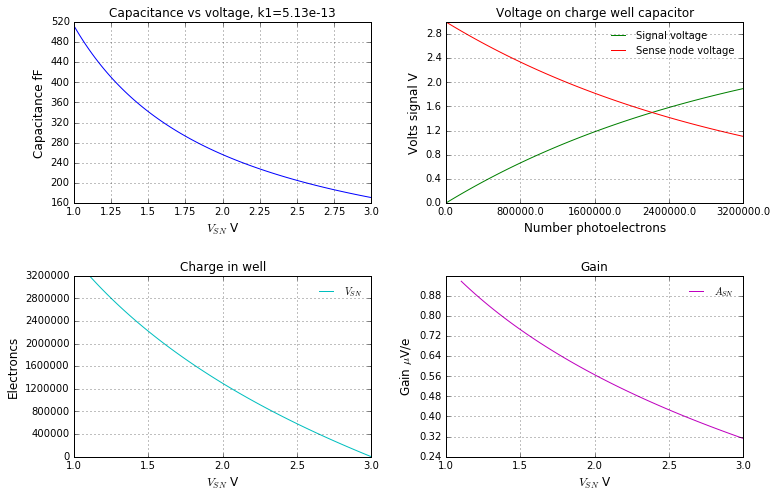

In [2]:
nwell = 3.2e6
vref = 3.0
vsnmin = 1.0
cwell = nwell * const.e / vsnmin
k1 = cwell * vsnmin
gain = const.e/cwell
print('Well capacitance {} F at {} V'.format(cwell,vsnmin))
print('k1 is {}'.format(k1))
print('Gain {} V/e at {} V'.format(gain,vsnmin))

nphelec = np.linspace(0,nwell,100)
vsnp = np.linspace(vsnmin,vref,100)
p = ryplot.Plotter(1,2,2,figsize=(12,8));
p.plot(1,vsnp,1e15*k1/vsnp,'Capacitance vs voltage, k1={:.2e}'.format(k1),
       '$V_{SN}$ V','Capacitance fF');
vsignal = vref * (1.0 - np.exp(- nphelec * const.e / (k1)))
vsn = vref * (np.exp(- nphelec * const.e / (k1)))
p.plot(2,nphelec, vsignal,'Voltage on charge well capacitor','Number photoelectrons','Volts signal V',
       label=['Signal voltage'],maxNX=5);
p.plot(2,nphelec, vsn,label=['Sense node voltage'],maxNX=5);

nelec = -(k1/const.e)*np.log(vsn/vref)
p.plot(3, vsn, nelec,'Charge in well','$V_{SN}$ V','Electroncs',label=['$V_{SN}$'],maxNX=5);
p.plot(4, vsn, 1e6*const.e*vsnp/k1,'Gain','$V_{SN}$ V','Gain $\mu$V/e',label=['$A_{SN}$'],maxNX=5);



The following code sets up the sensor model data for an infrared sensor.

Files remaining open, not closed after use, poses a problem in the notebook context where cells may be executed indivdually.  To limit the occurence of open files we open and close the file in each cell.

In [3]:
#set up the parameters for this run and open the HDF5 file
outfilenameIR = 'OutputIR'
prefix = 'PA'
hfname = 'image-E-W-m2-detector-100-256-100-256.hdf5'
urlname = 'https://github.com/NelisW/pyradi/raw/master/pyradi/data/{}'.format(hfname)
pathtoimage = ryfiles.downloadFileUrl(urlname,saveFilename=hfname)

#open the file to create data structure and store the results, remove if exists
hdffilenameIR = '{}{}.hdf5'.format(prefix, outfilenameIR)
if os.path.isfile(hdffilenameIR):
    os.remove(hdffilenameIR)

In [4]:
strh5 = ryfiles.open_HDF(hdffilenameIR)
# Light Noise parameters
strh5['rystare/photonshotnoise/activate'] = True #photon shot noise.

#sensor parameters
strh5['rystare/sensortype'] = 'CMOS' # CMOS/CCD must be in capitals

strh5['rystare/photondetector/operatingtemperature'] = 80. # operating temperature, [K]
strh5['rystare/photondetector/geometry/fillfactor'] = 0.95 # Pixel Fill Factor for full-frame CCD photo sensors.
strh5['rystare/photondetector/integrationtime'] = 0.005 # Exposure/Integration time, [sec].
strh5['rystare/photondetector/externalquantumeff'] = 1.  # external quantum efficiency, fraction not reflected.
strh5['rystare/photondetector/quantumyield'] = 1. # number of electrons absorbed per one photon into material bulk

# photo response non-uniformity noise (PRNU), or also called light Fixed Pattern Noise (light FPN)
strh5['rystare/photondetector/lightPRNU/activate'] = True
strh5['rystare/photondetector/lightPRNU/seed'] = 362436069
strh5['rystare/photondetector/lightPRNU/model'] = 'Janesick-Gaussian' 
strh5['rystare/photondetector/lightPRNU/sigma'] = 0.002 # sigma [about 1\% for CCD and up to 5% for CMOS];

# detector material bandgap properties 
strh5['rystare/photondetector/varshni/Egap0'] = 0.235  #bandgap energy for 0 degrees of K. [eV]
strh5['rystare/photondetector/varshni/varA'] = 3e-04 #Si material parameter, [eV/K].
strh5['rystare/photondetector/varshni/varB'] = 500. #Si material parameter, [K].

# Dark Current Noise parameters
strh5['rystare/photondetector/darkcurrent/activate'] = True
strh5['rystare/photondetector/darkcurrent/ca'] = 2.78e4 # for density in m2
strh5['rystare/photondetector/darkcurrent/ed'] = 2. 
strh5['rystare/photondetector/darkcurrent/densityAm2'] = 2e-6 # dark current density [A/m2].  
strh5['rystare/photondetector/darkcurrent/shotnoise/activate'] = True # dark current shot noise
strh5['rystare/photondetector/darkcurrent/shotnoise/seed'] = 6214069 
strh5['rystare/photondetector/darkcurrent/shotnoise/model'] = 'Gaussian' 

#dark current Fixed Pattern uniformity 
strh5['rystare/photondetector/darkcurrent/fixedPatternNoise/activate'] = True
strh5['rystare/photondetector/darkcurrent/fixedPatternNoise/seed'] = 362436128
strh5['rystare/photondetector/darkcurrent/fixedPatternNoise/model'] = 'Janesick-Gaussian' #suitable for long exposures
strh5['rystare/photondetector/darkcurrent/fixedPatternNoise/sigma'] = 0.4 #lognorm_sigma.

#sense node charge to voltage
strh5['rystare/sensenode/gain'] = 3.125e-07 # Sense node gain, A_SN [V/e]
strh5['rystare/sensenode/vrefreset'] = 3. # Reference voltage to reset the sense node. [V] typically 3-10 V.
strh5['rystare/sensenode/vsnmin'] = 1.0 # Minimum voltage on sense node, max well charge [V] typically < 1 V.
strh5['rystare/sensenode/gainresponse/type'] = 'linear'
strh5['rystare/sensenode/gainresponse/k1'] = 5.13e-13 # nonlinear capacitance is given by C =  k1/V
if strh5['rystare/sensenode/gainresponse/type'] in ['nonlinear']:
    strh5['rystare/sensenode/fullwellelectronselection/fullwellelectrons'] = \
        -(strh5['rystare/sensenode/gainresponse/k1'].value/const.e) * \
        np.log(strh5['rystare/sensenode/vsnmin'].value/strh5['rystare/sensenode/vrefreset'].value)
else:
    strh5['rystare/sensenode/fullwellelectronselection/fullwellelectrons'] = 3.2e6 # full well of the pixel (how many electrons can be stored in one pixel), [e]
strh5['rystare/sensenode/resetnoise/activate'] = True
strh5['rystare/sensenode/resetnoise/seed'] = 2154069 
strh5['rystare/sensenode/resetnoise/model'] = 'Gaussian' 
strh5['rystare/sensenode/resetnoise/factor'] = 0.8 #[0,1]the compensation factor of the Sense Node Reset Noise: 

#source follower
strh5['rystare/sourcefollower/gain'] = 1. # Source follower gain, [V/V], lower means amplify the noise.
strh5['rystare/sourcefollower/dataclockspeed'] = 10e6 #Hz data rate clocking speed.
strh5['rystare/sourcefollower/freqsamplingdelta'] = 10000. #Hz spectral sampling spacing
strh5['rystare/sourcefollower/noise/activate'] = True
strh5['rystare/sourcefollower/noise/seed'] = 6724069
strh5['rystare/sourcefollower/noise/flickerCornerHz'] = 1e6 #flicker noise corner frequency $f_c$ in [Hz], where power spectrum of white and flicker noise are equal [Hz].
strh5['rystare/sourcefollower/noise/whitenoisedensity'] = 15e-9 #thermal white noise [\f$V/Hz^{1/2}\f$, typically \f$15 nV/Hz^{1/2}\f$ ]
strh5['rystare/sourcefollower/noise/deltaindmodulation'] = 1e-8 #[A] source follower current modulation induced by RTS [CMOS ONLY]
strh5['rystare/sourcefollower/nonlinearity/activate'] = True
strh5['rystare/sourcefollower/nonlinearity/ratio'] = 1.05 # > 1 for lower signal, < 1 for higher signal

#dark current Offset Fixed Pattern 
strh5['rystare/sourcefollower/fpoffset/activate'] = True
strh5['rystare/sourcefollower/fpoffset/model'] = 'Janesick-Gaussian'
strh5['rystare/sourcefollower/fpoffset/sigma'] = 0.0005 # percentage of (V_REF - V_SN)
strh5['rystare/sourcefollower/fpoffset/seed'] = 362436042

# Correlated Double Sampling (CDS)
strh5['rystare/sourcefollower/CDS/gain'] = 1. # CDS gain, [V/V], lower means amplify the noise.
strh5['rystare/sourcefollower/CDS/sampletosamplingtime'] = 1e-6 #CDS sample-to-sampling time [sec].

# Analogue-to-Digital Converter (ADC)
strh5['rystare/ADC/num-bits'] = 16. # noise is more apparent on high Bits
strh5['rystare/ADC/offset'] = 0. # Offset of the ADC, in DN
strh5['rystare/ADC/nonlinearity/activate'] = True 
strh5['rystare/ADC/nonlinearity/ratio'] = 1.05

#For testing and measurements only:
strh5['rystare/darkframe'] = False # True if no signal, only dark

    
strh5.flush()
strh5.close()

Download the image file from the GitHub directory. Normally you will prepare this file for your specific application.  The format for this file is described [here](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html#pyradi.rystare.create_HDF5_image).

In [5]:

if pathtoimage is not None:
    imghd5 = ryfiles.open_HDF(pathtoimage)
else:
    imghd5 = None  

The input data has been set up, now execute the model. To test the model performance at the limits, uncomment one of the two `scaleInput` lines.  The first line provides a signal with small SNR whereas the second line provides a signal that saturates the well.

In [6]:
##
scaleInput = 1 

if imghd5 is not None:
    strh5 = ryfiles.open_HDF(hdffilenameIR)
    
    #images must be in photon rate irradiance units q/(m2.s)
    
    strh5['rystare/equivalentSignal'] = scaleInput * imghd5['image/equivalentSignal'].value
    strh5['rystare/signal/photonRateIrradianceNoNoise'] = scaleInput * imghd5['image/PhotonRateIrradianceNoNoise'].value
    strh5['rystare/signal/photonRateIrradiance'] = scaleInput * imghd5['image/PhotonRateIrradiance'].value
    strh5['rystare/pixelPitch'] = imghd5['image/pixelPitch'].value
    strh5['rystare/imageName'] = imghd5['image/imageName'].value
    strh5['rystare/imageFilename'] = imghd5['image/imageFilename'].value
    strh5['rystare/imageSizePixels'] = imghd5['image/imageSizePixels'].value
    strh5['rystare/wavelength'] = imghd5['image/wavelength'].value
    strh5['rystare/imageSizeRows'] = imghd5['image/imageSizeRows'].value
    strh5['rystare/imageSizeCols'] = imghd5['image/imageSizeCols'].value
    strh5['rystare/imageSizeDiagonal'] = imghd5['image/imageSizeDiagonal'].value
    strh5['rystare/equivalentSignalUnit'] = imghd5['image/equivalentSignalUnit'].value
    strh5['rystare/equivalentSignalType'] = imghd5['image/equivalentSignalType'].value
    strh5['rystare/EinUnits'] = imghd5['image/EinUnits'].value

    #calculate the noise and final images
    strh5 = rystare.photosensor(strh5) # here the Photon-to-electron conversion occurred.
    strh5.flush()
    strh5.close()


In [7]:
print(hdffilenameIR)

PAOutputIR.hdf5


Print some statistics of the sensor, noise and image

In [8]:
print(rystare.get_summary_stats(hdffilenameIR))

PAOutputIR.hdf5
Image file name             : image-E-W-m2-detector-100-256-100-256.hdf5
Image name                  : E-W-m2-detector-100-256-1
Input image type            : W/m2 on detector plane
Sensor type                 : CMOS 
Pixel pitch                 : [  1.20000000e-05   1.20000000e-05] m
Image size diagonal         : 0.00329805761017 m
Image size pixels           : [100 256] 
Fill factor                 : 0.95
Full well electrons         : 3200000.0 e
Integration time            : 0.005 s
Wavelength                  : 4.5e-06 m
Operating temperature       : 80.0 K
Max equivalent input signal : 0.120830185711 W/m2
Min equivalent input signal : 0.0596921443939 W/m2
EquivalentSignal type       : Irradiance W/m2
PhotonRateIrradianceNoNoise : q/(m2.s) mean=1.97865e+18, var=inf
SignalPhotonRateIrradiance  : q/(m2.s) mean=1.97865e+18, var=inf
SignalPhotonsNU             : q/(m2.s) mean=1.97866e+18, var=1.67417e+35
signalLightNoShotNoise      : e mean=1.35340e+06, var=7.83271e+10


Print some statistics of the sensor, noise and image

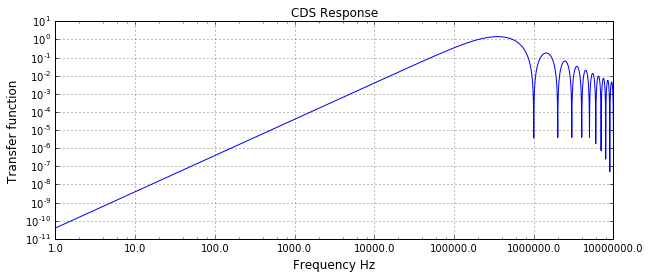

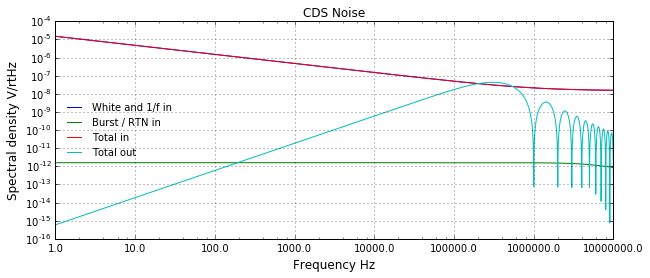

In [9]:
#open the sensor data file
%matplotlib inline
strh5 = ryfiles.open_HDF(hdffilenameIR)
p = ryplot.Plotter(1,1,1,figsize=(10,4))
p.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         strh5['rystare/sourcefollower/noise/cdsgain'].value.T,'CDS Response',
        'Frequency Hz','Transfer function')
q = ryplot.Plotter(2,1,1,figsize=(10,4))
q.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         np.sqrt(strh5['rystare/sourcefollower/noise/spectrumwhiteflicker'].value.T),label=['White and 1/f in'])
if strh5['rystare/sensortype'].value in ['CMOS']:
    q.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         np.sqrt(strh5['rystare/sourcefollower/noise/spectrumRTN'].value.T), label=['Burst / RTN in'])
q.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         np.sqrt(strh5['rystare/sourcefollower/noise/spectrumtotal'].value.T),label=['Total in'])
q.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         np.sqrt(strh5['rystare/sourcefollower/noise/spectrumtotal'].value.T) * strh5['rystare/sourcefollower/noise/cdsgain'].value.T,'CDS Noise',
        'Frequency Hz','Spectral density V/rtHz',label=['Total out'])
strh5.flush()
strh5.close()

In [10]:
def plotResults(imghd5, hdffilenameIR, arrayname, bins=50, plotscale=1.0, logscale=False):
    if imghd5 is not None and hdffilenameIR is not None:
        #open the sensor data file
        strh5 = ryfiles.open_HDF(hdffilenameIR)
        #get the prescribed array
        arr = strh5['{}'.format(arrayname)].value 
        maxarr = np.max(arr)
        arr = strh5['{}'.format(arrayname)].value * plotscale
        arr = np.where(arr > maxarr, maxarr,arr) / plotscale
        if logscale:
            arr = np.log10(arr + 0.5)
            ptitle = "log('{}'+0.5)".format(arrayname.replace('rystare/',''))
        else:
            ptitle = "'{}'".format(arrayname.replace('rystare/',''))
        
        his, binh = np.histogram(arr,bins=bins)
        
        if np.min(arr) != np.max(arr):
            arrshift = arr - np.min(arr)
            arrshift = 255 * arrshift/np.max(arrshift)
            p = ryplot.Plotter(1,1,1,figsize=(8, 2))
#             p.showImage(1, arr, ptitle=ptitle, cmap=ryplot.cubehelixcmap(), cbarshow=True);
            p.showImage(1, arr, ptitle=ptitle, cmap=mcm.jet, cbarshow=True);
            q = ryplot.Plotter(2,1,1,figsize=(8, 2))
            q.showImage(1, arrshift, ptitle=ptitle, cmap=mcm.gray, cbarshow=False);
        if not logscale:
            r = ryplot.Plotter(3,1,1,figsize=(7, 2))
            r.plot(1, (binh[1:]+binh[:-1])/2, his, 
                   '{}, {} bins'.format(arrayname.replace('rystare/',''), bins), 
                   'Magnitude','Counts / bin',maxNX=5)

        strh5.flush()
        strh5.close()

The graph in the rest of the document shows signals at the stations marked in the signal flow diagram shown below.

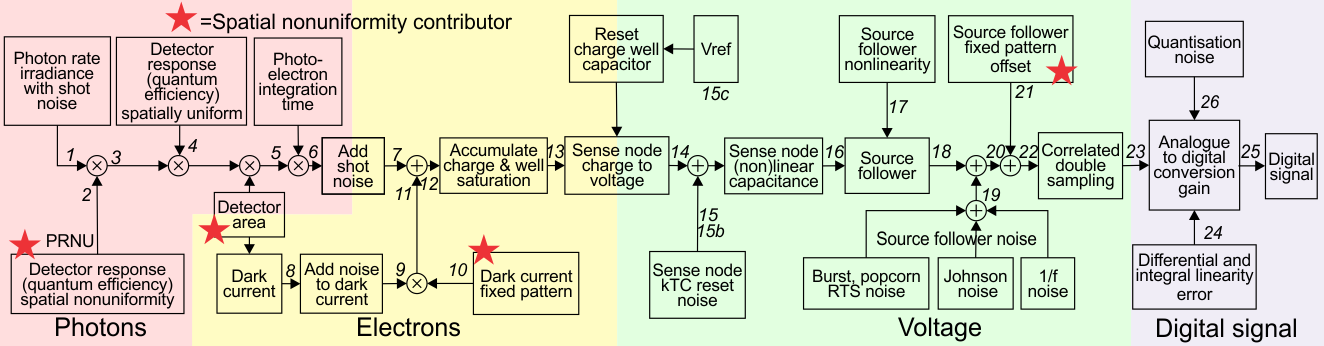

In [11]:
display(Image(filename='images/camerascheme-horiz.png', width=1000))

The following description follows  the signal through the processing chain, step by step, showing the relevant signal or noise at that step.

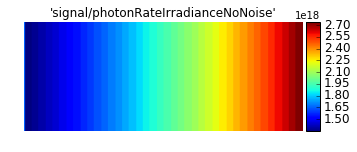

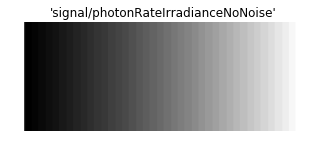

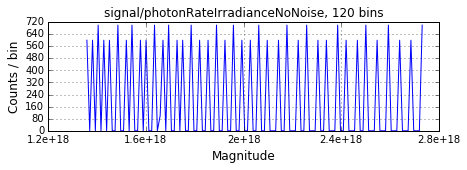

In [12]:
##
plotResults(imghd5, hdffilenameIR, 'rystare/signal/photonRateIrradianceNoNoise', bins=120) 

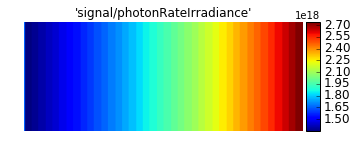

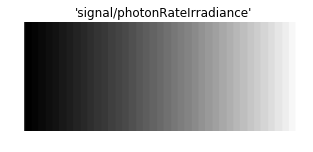

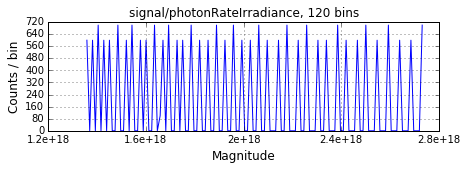

In [13]:
##
plotResults(imghd5, hdffilenameIR, 'rystare/signal/photonRateIrradiance', bins=120) 

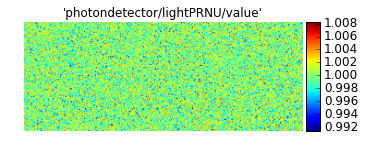

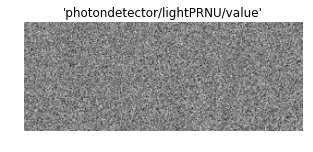

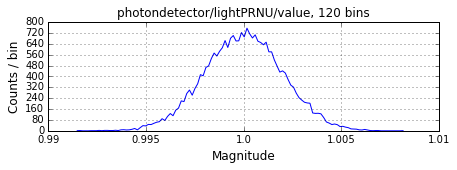

In [14]:
##
plotResults(imghd5, hdffilenameIR, 'rystare/photondetector/lightPRNU/value', bins=120) 

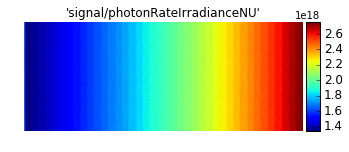

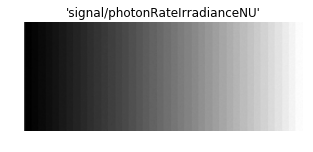

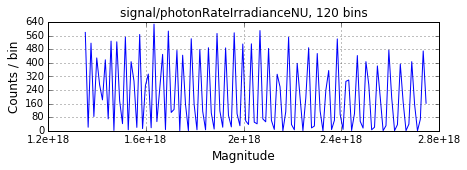

In [15]:
##
plotResults(imghd5, hdffilenameIR, 'rystare/signal/photonRateIrradianceNU', bins=120) 

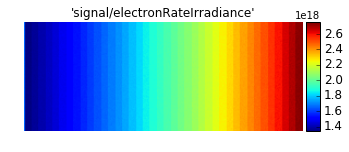

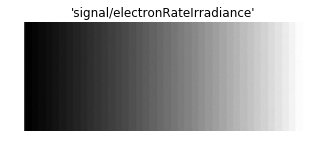

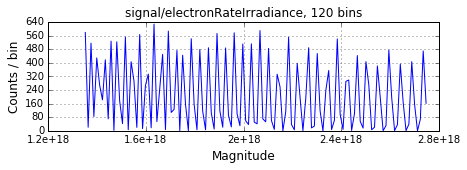

In [16]:
##
plotResults(imghd5, hdffilenameIR, 'rystare/signal/electronRateIrradiance', bins=120) 

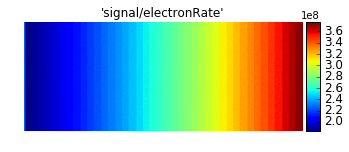

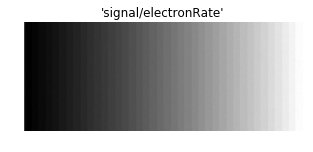

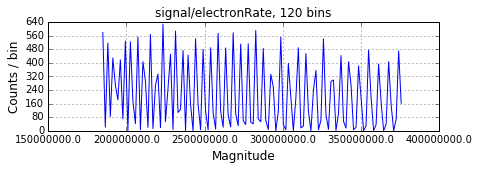

In [17]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/electronRate', bins=120) 

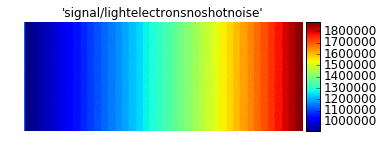

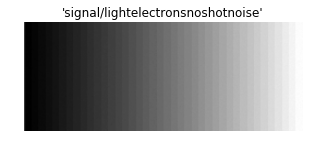

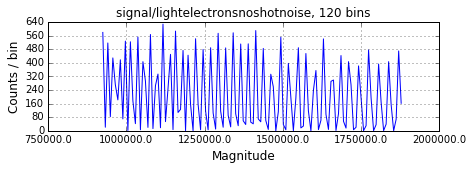

In [18]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/lightelectronsnoshotnoise', bins=120) 

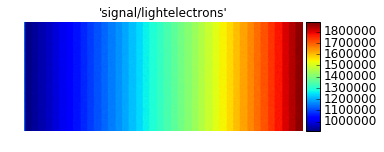

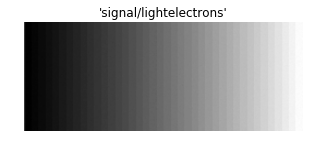

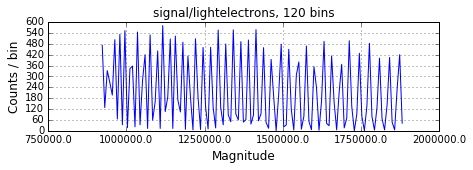

In [19]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/lightelectrons', bins=120) 

In [20]:
##
strh5 = ryfiles.open_HDF(hdffilenameIR)
print('Average dark current {:.3e} electrons'.format(strh5['rystare/darkcurrentelectronsnonoise'].value))
strh5.flush()
strh5.close()


Average dark current 9.004e+00 electrons


Before dark FPN:
Minimum dark current 0.000e+00 electrons
Average dark current 9.019e+00 electrons
Maximum dark current 2.300e+01 electrons
After dark FPN:
Minimum dark current 0.000e+00 electrons
Average dark current 9.091e+00 electrons
Maximum dark current 4.211e+01 electrons


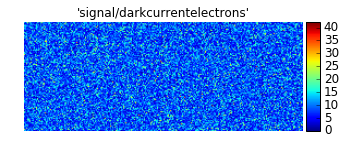

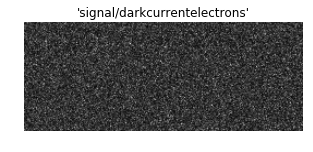

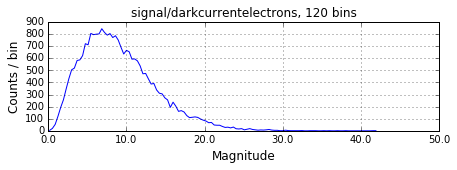

In [21]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/darkcurrentelectrons', bins=120) 



strh5 = ryfiles.open_HDF(hdffilenameIR)
print('Before dark FPN:')
print('Minimum dark current {:.3e} electrons'.format(np.min(strh5['rystare/signal/darkcurrentelectronsnoDFPN'].value)))
print('Average dark current {:.3e} electrons'.format(np.mean(strh5['rystare/signal/darkcurrentelectronsnoDFPN'].value)))
print('Maximum dark current {:.3e} electrons'.format(np.max(strh5['rystare/signal/darkcurrentelectronsnoDFPN'].value)))
print('After dark FPN:')
print('Minimum dark current {:.3e} electrons'.format(np.min(strh5['rystare/signal/darkcurrentelectrons'].value)))
print('Average dark current {:.3e} electrons'.format(np.mean(strh5['rystare/signal/darkcurrentelectrons'].value)))
print('Maximum dark current {:.3e} electrons'.format(np.max(strh5['rystare/signal/darkcurrentelectrons'].value)))
strh5.flush()
strh5.close()

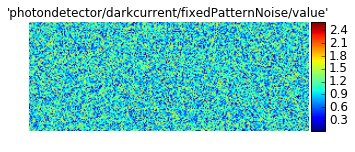

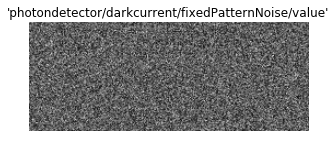

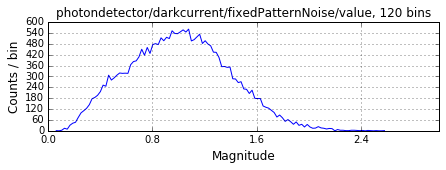

In [22]:
plotResults(imghd5, hdffilenameIR, 'rystare/photondetector/darkcurrent/fixedPatternNoise/value', bins=120) 

Location 11 in the diagram: dark current with noise multiplied with the dark current nonuniformity.\newline 
Variable: \url{rystare/signal/darkcurrentelectrons}.


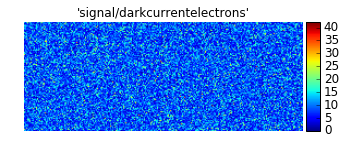

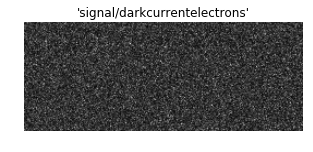

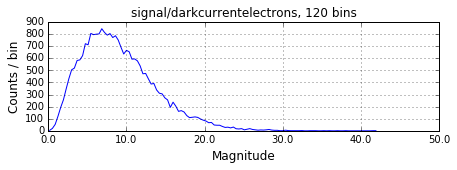

In [23]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/darkcurrentelectrons', bins=120) 

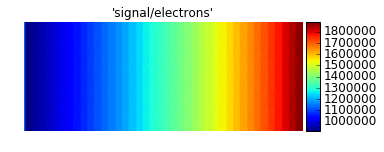

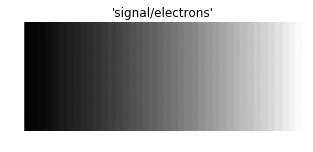

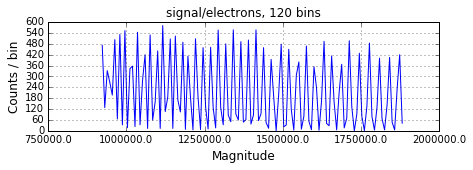

In [24]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/electrons', bins=120) 

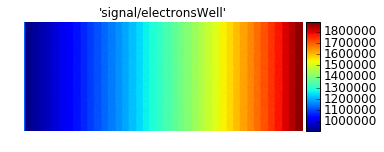

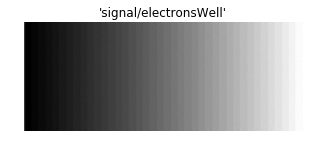

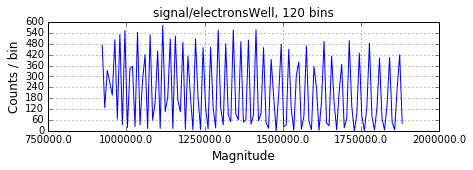

In [25]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/electronsWell', bins=120) 


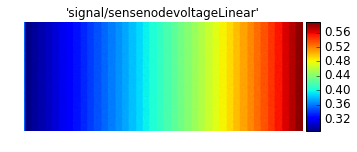

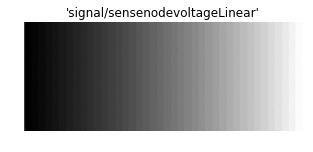

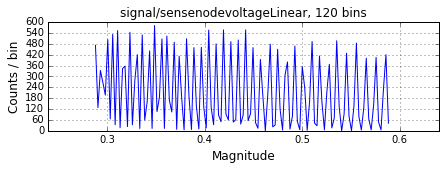

In [26]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/sensenodevoltageLinear', bins=120) 

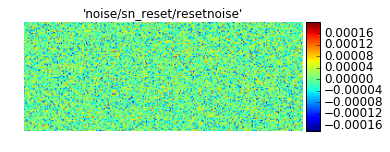

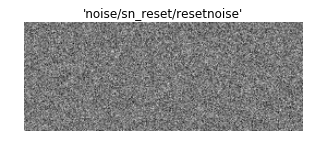

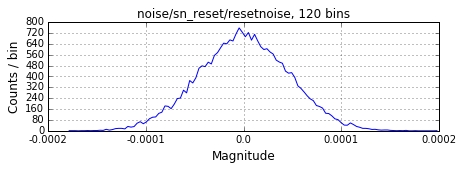

In [27]:
plotResults(imghd5, hdffilenameIR, 'rystare/noise/sn_reset/resetnoise', bins=120) 

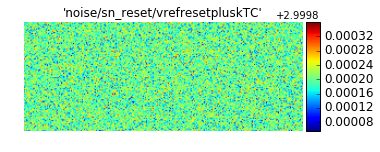

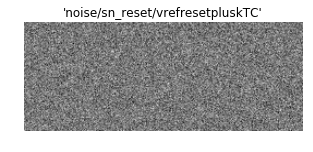

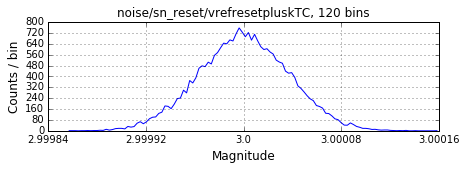

In [28]:
plotResults(imghd5, hdffilenameIR, 'rystare/noise/sn_reset/vrefresetpluskTC', bins=120) 

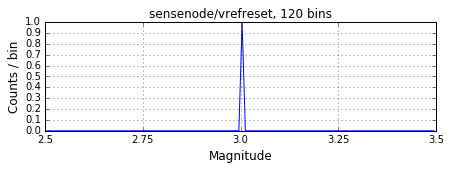

In [29]:
plotResults(imghd5, hdffilenameIR, 'rystare/sensenode/vrefreset', bins=120) 

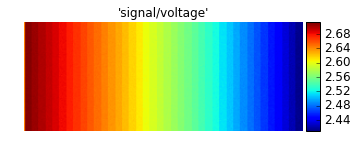

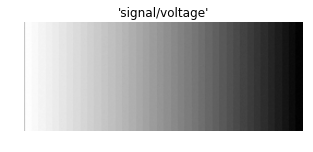

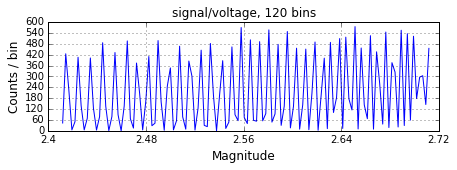

In [30]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/voltage', bins=120) 

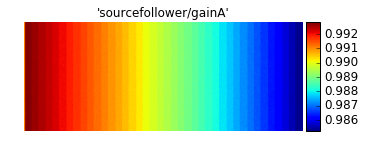

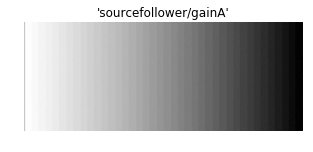

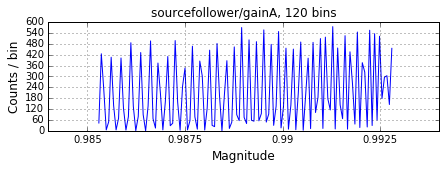

In [31]:
plotResults(imghd5, hdffilenameIR, 'rystare/sourcefollower/gainA', bins=120) 

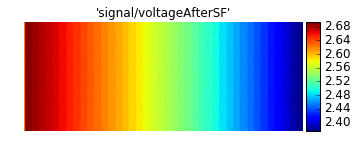

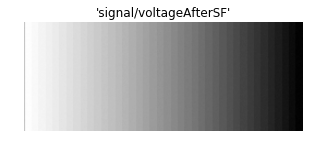

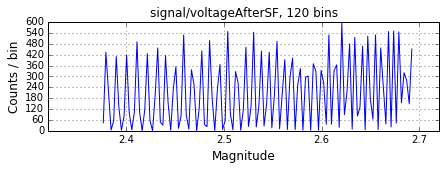

In [32]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/voltageAfterSF', bins=120) 

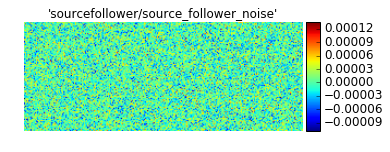

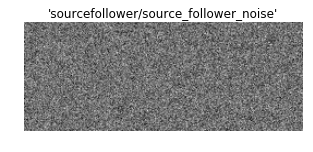

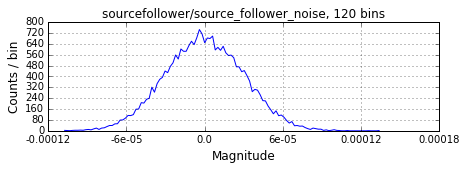

In [33]:
plotResults(imghd5, hdffilenameIR, 'rystare/sourcefollower/source_follower_noise', bins=120) 

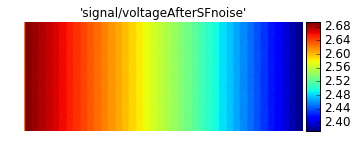

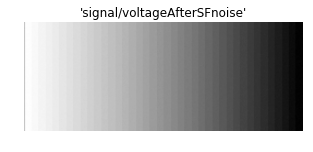

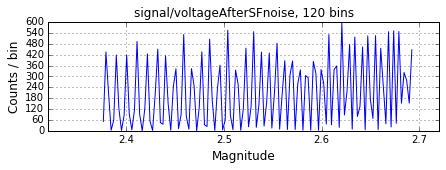

In [34]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/voltageAfterSFnoise', bins=120) 

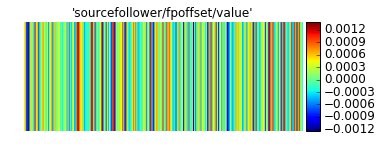

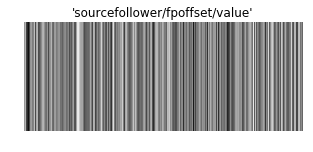

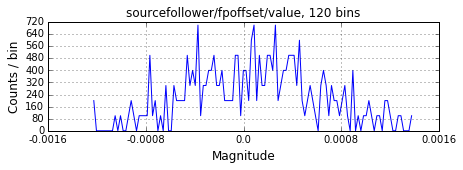

In [35]:
plotResults(imghd5, hdffilenameIR, 'rystare/sourcefollower/fpoffset/value', bins=120) 

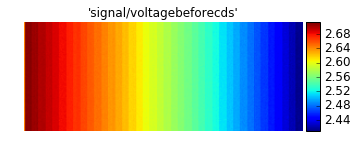

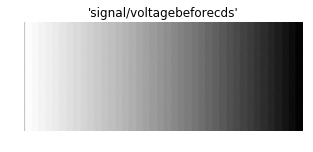

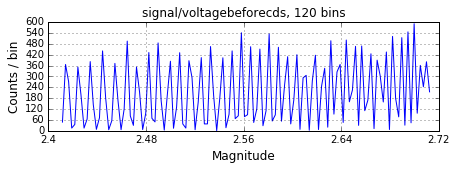

In [36]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/voltagebeforecds', bins=120) 

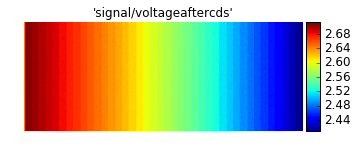

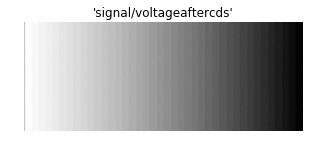

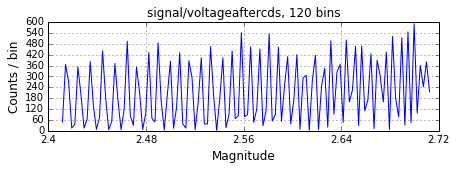

In [37]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/voltageaftercds', bins=120) 

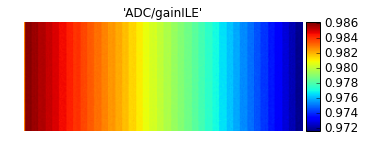

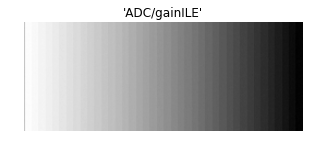

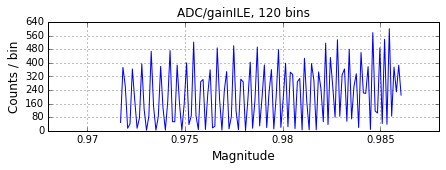

In [38]:
plotResults(imghd5, hdffilenameIR, 'rystare/ADC/gainILE', bins=120) 

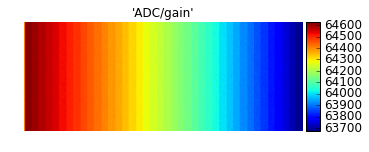

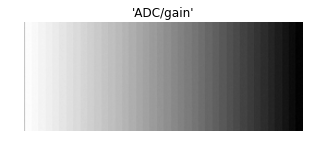

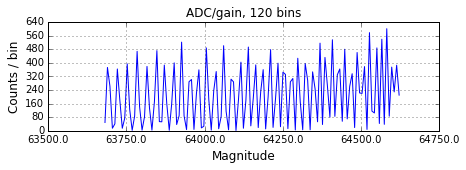

In [39]:
plotResults(imghd5, hdffilenameIR, 'rystare/ADC/gain', bins=120) 

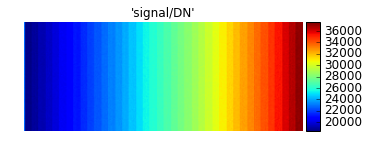

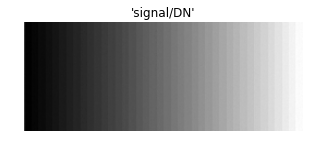

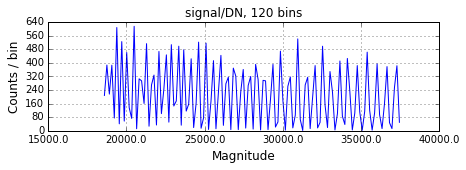

In [40]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/DN', bins=120) 

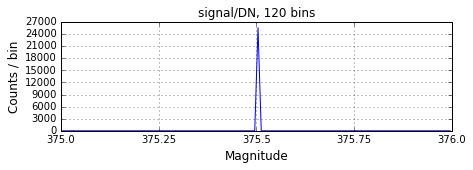

In [41]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/DN', bins=120, plotscale=100) 

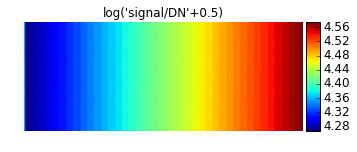

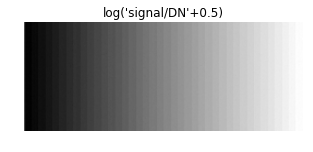

In [42]:
plotResults(imghd5, hdffilenameIR, 'rystare/signal/DN', bins=120, plotscale=1, logscale=True) 

Next we will attempt to calculate the photon transfer function and signal to noise ratio for the various parts of the image.

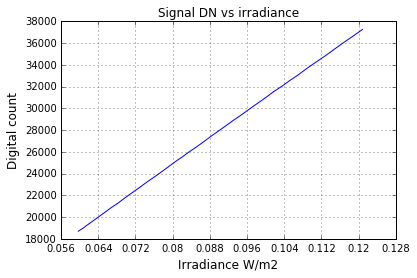

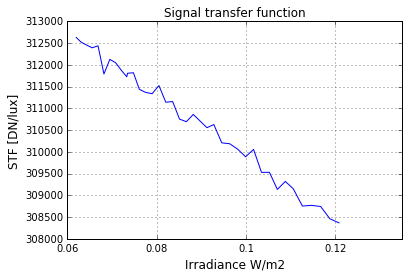

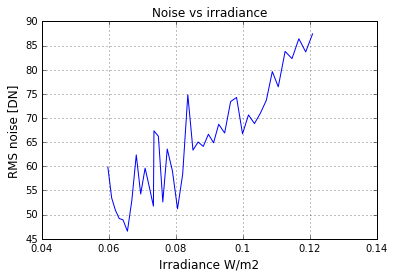

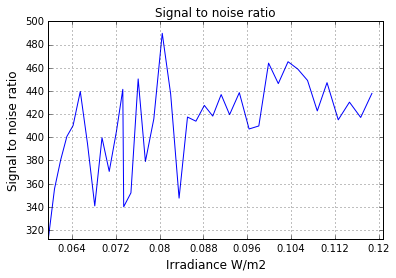

In [43]:
tplZones = collections.namedtuple('tplZones', ['ein', 'count','mean','var','std','snr','stf'], verbose=False)
lstZones = []
if imghd5 is not None:
    strh5 = ryfiles.open_HDF(hdffilenameIR)
    #get the list of unique zones in the image
    arrnn = strh5['rystare/equivalentSignal'].value
#     arrnn = strh5['rystare/PhotonRateIrradianceNoNoise'].value
    arr = strh5['rystare/signal/DN'].value
    uniqueZs, uCnts = np.unique(arrnn, return_counts=True)
#     print(uniqueZs, uCnts)
    for uniqueZ,ucnt in zip(uniqueZs,uCnts):
        zone = arr[arrnn==uniqueZ]
        mean = np.mean(zone)
        lstZones.append(tplZones(ein=uniqueZ, count=ucnt, mean=mean, 
                        var=np.var(zone-mean), std=np.std(zone-mean), 
                        snr=np.mean(zone)/np.std(zone-mean),
                        stf=np.mean(zone)/uniqueZ))
    equivalentSignalLabel = '{} {}'.format(strh5['rystare/equivalentSignalType'].value,
                                       strh5['rystare/equivalentSignalUnit'].value)

    strh5.flush()
    strh5.close()


# print(lstZones) 
#build numpy arrays of the results
ein = np.asarray([x.ein for x in lstZones])
mean = np.asarray([x.mean for x in lstZones])
var = np.asarray([x.var for x in lstZones])
std = np.asarray([x.std for x in lstZones])
snr = np.asarray([x.snr for x in lstZones])
stf = np.asarray([x.stf for x in lstZones])


figsize = (6,4)
p = ryplot.Plotter(1,1,1,figsize=figsize);
p.plot(1,ein,mean,'Signal DN vs irradiance',equivalentSignalLabel,'Digital count');
q = ryplot.Plotter(2,1,1,figsize=figsize);
q.plot(1,ein[2:],stf[2:],'Signal transfer function',equivalentSignalLabel,'STF [DN/lux]',maxNX=5);
r = ryplot.Plotter(3,1,1,figsize=figsize);
r.plot(1,ein,std,'Noise vs irradiance',equivalentSignalLabel,'RMS noise [DN]',maxNX=5);
s = ryplot.Plotter(4,1,1,figsize=figsize);
s.plot(1,ein[:-1],snr[:-1],'Signal to noise ratio',equivalentSignalLabel,'Signal to noise ratio',
        pltaxis=[ein[0],ein[-1], np.min(snr[:-1]),500]);
# s.logLog(1,mean[:-1],snr[:-1],'SNR [-] vs mean [DN]');


## Comments

1.  The small target image used here is relatively small and does not provide adequate statistics.  It serves as proof-of-concept in this analysis.

1. A more detailed discussion of the results will be done in due course.



## Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [44]:
# you only need to do this once
#!pip install --upgrade version_information

%load_ext version_information
%version_information numpy, scipy, matplotlib, pyradi

Software versions
Python 2.7.12 64bit [MSC v.1500 64 bit (AMD64)]
IPython 5.1.0
OS Windows 7 6.1.7601 SP1
numpy 1.11.1
scipy 0.18.1
matplotlib 1.5.3
pyradi 0.2.3
Sat Oct 22 16:18:07 2016 South Africa Standard Time